# Machine learning report - Credit card fraud detection

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from CustomTransformers import ColumnDropperTransformer, DateFormaterTransformer, IdFormaterTransforer, OneHotEncoderTransformer, OversamplingTransformer
from sklearn.model_selection import train_test_split

training_file_path = 'training.csv'
X = pd.read_csv(training_file_path)

test_file_path = 'test.csv'
X_test = pd.read_csv(test_file_path)

X_test_id = X_test['TransactionId']

## 1. Préparation des données
### 1.1 Exploration des données
Nous allons commencer par explorer les données afin de voir si elles sont exploitables et si elles nécessitent un traitement particulier.

Les points d'attention sont les suivants :
- Les données contiennent-elles des valeurs manquantes ?
- Les données contiennent-elles des variables catégorielles ?
- Les données sont elles équilibrées ?
- Les données sont elles au format numérique ?

In [47]:
# On print le nombre de valeurs manquantes par colonne
print(f"Valeurs manquantes: {X.isnull().sum()}")

# On mesure l'équilibre des classes
X_train_no_fraud = X[X['FraudResult']==0]
X_train_fraud = X[X['FraudResult']==1]

percentage_minority = len(X_train_fraud)/(len(X_train_no_fraud) + len(X_train_fraud)) * 100
print(f"Pourcentage de fraude: {round(percentage_minority, 2)}%")

# On print le type de chaque colonne
print(f"Types:{X.dtypes}")

# On print le nombre de valeurs uniques par colonne
print(f"Valeurs uniques: {X.nunique()}")

# On print les premières lignes du dataset
print(f"Premières lignes: {X.head()}")

# On print les statistiques descriptives du dataset
print(f"Statistiques descriptives: {X.describe()}")

Valeurs manquantes: TransactionId           0
BatchId                 0
AccountId               0
SubscriptionId          0
CustomerId              0
CurrencyCode            0
CountryCode             0
ProviderId              0
ProductId               0
ProductCategory         0
ChannelId               0
Amount                  0
Value                   0
TransactionStartTime    0
PricingStrategy         0
FraudResult             0
dtype: int64
Pourcentage de fraude: 0.2%
Types:TransactionId            object
BatchId                  object
AccountId                object
SubscriptionId           object
CustomerId               object
CurrencyCode             object
CountryCode               int64
ProviderId               object
ProductId                object
ProductCategory          object
ChannelId                object
Amount                  float64
Value                     int64
TransactionStartTime     object
PricingStrategy           int64
FraudResult               int64
dtype

In [48]:
y = X['FraudResult']
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

preprocessor = Pipeline(steps=[
    ('drop_columns', ColumnDropperTransformer()),
    ('id_formater', IdFormaterTransforer()),
    # ('date_formater', DateFormaterTransformer()),
    ('one_hot_encoder', OneHotEncoderTransformer()),
    ('oversampling', OversamplingTransformer())
])
X = preprocessor.transform(X)
y = X['FraudResult']
X = X.drop('FraudResult', axis=1)


X_train = preprocessor.fit_transform(X_train)
y_train = X_train['FraudResult']
X_train = X_train.drop('FraudResult', axis=1)

X_valid = preprocessor.transform(X_valid)
y_valid = X_valid['FraudResult']
X_valid = X_valid.drop('FraudResult', axis=1)

X_test = preprocessor.transform(X_test)

X_train.head()
#X_test.head()

,AccountId,SubscriptionId,CustomerId,ProductId,Amount,Value,0,1,2,3,...,13,14,15,16,17,18,19,20,21,22
67346,4841,3829,3678,6,-50.0,50,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
37588,2739,791,3160,15,20000.0,20000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
87804,4841,3829,3323,6,-392.0,392,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
48482,2504,4010,2920,11,500.0,500,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
85364,4841,3829,3066,6,-50.0,50,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Voici les observations que nous avons faites sur les données :
- Les données ne contiennent pas de valeurs manquantes
- Les données sont fort déséquilibrées (0,2% de fraudes)
- Des données qui devraient être numériques sont au format object
- **CurrencyCode** et **CountryCode** ne sont pas exploitables car elles ne contienent qu'une seule valeur
- **ProviderId**, **ProductId**, **ProductCategory**, **ChannelId** et **PricingStrategy** sont des variables catégorielles

### 1.2 Rééquilibrage des données
Face a un jeu de données en déséquilibre, deux solutions s'offrent à nous:
- Effectuer un oversampling de la classe minoritaire (fraud) en créant des observations de cette classe.
- Effectuer un undersampling de la classe majoritaire (normal) en supprimant des observations de cette classe.

Nous allons ici choisir la première solution, en utilisant la methode resample de la librairie sklearn. Celle ci va nous permettre de créer un dataset équilibré en augmentant le nombre d'observations de la classe minoritaire.

### 1.3 Selection des variables
Nous allons ici sélectionner les variables qui nous semblent pertinentes pour la prédiction. Nous allons donc retirer les variables suivantes :
- **CurrencyCode** et **CountryCode** car elles ne contiennent qu'une seule valeur
- **BatchId** car il s'agit de l'identifiant d'un groupe de transactions, non disponible au moment de la transaction et a priori pas lié à la fraude
- **TransactionId** car il s'agit d'un identifiant unique, a priori non lié à la fraude

### 1.4 Conversion des variables numériques
Nous allons convertir les variables numériques au format object en variables numériques au format int. Pour cela nous retirons la partie texte des valeurs et nous convertissons le résultat en int.

### 1.5 Encodage des variables catégorielles
Nous allons encoder les variables catégorielles de deux manières différentes :
- **One hot encoding** pour les variables contenants moins de 10 modalités
- **Target encoding** pour les variables contenant plus de 10 modalités

On fera donc du **one hot encoding** sur les variables **ProviderId**, **ProductCategory**, **ChannelId** et **PricingStrategy**.
**ProductId** contient 23 modalités, nous allons donc faire du **target encoding** sur cette variable. Il est cependant déjà au format int, nous n'avons donc pas besoin de le convertir.

## 2. Modélisation
### 2.1. Séparation des données
Nous allons ici séparer nos données en deux jeux de données:
- Un jeu de données d'entrainement (80% des données)
- Un jeu de données de test (20% des données)
Ceci nous permettra de tester la performance de notre modèle sur des données qu'il n'a jamais vu.

### 2.2 Choix du modèle
Nous allons ici tester différents modèles de classification afin de voir lequel est le plus performant sur notre jeu de données. Nous allons tester les modèles suivants :
- **Régression logistique**
- **Arbre de décision**
- **Random forest**
- **XGBoost**
### 2.3. Optimisation des hyperparamètres
Nous allons ici optimiser les hyperparamètres du modèle qui nous semble le plus performant. Pour cela nous allons utiliser la méthode **GridSearchCV** de la librairie sklearn. Cette méthode va nous permettre de tester différentes combinaisons d'hyperparamètres et de choisir celle qui donne les meilleurs résultats.


In [41]:
# On définit nos modèles
from sklearn.linear_model import LogisticRegression
model_reg = LogisticRegression(random_state=0)
model_tree = DecisionTreeClassifier(max_depth=6, random_state=0)
model_random_forest = RandomForestClassifier(max_depth=10 ,n_estimators=50, random_state=0)
model_XGBoost = XGBClassifier(n_estimators=50, random_state=0, learning_rate=0.3, max_depth=2)

In [36]:
# Om importe GridSearchCV
from sklearn.model_selection import GridSearchCV

# Decision Tree
# On utilise le grid search pour trouver les meilleurs hyperparamètres qui maximisent le score f1
param_grid = {'max_depth': [17, 18, 19, 20, 21, 22]}
grid_search = GridSearchCV(model_tree, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# On plot les résultats
results = pd.DataFrame(grid_search.cv_results_)
plt.plot(results['param_max_depth'], results['mean_test_score'])
plt.xlabel('max_depth')
plt.ylabel('f1 score')
plt.show()

# On print les meilleurs hyperparamètres
print(grid_search.best_params_)


ValueError: Found input variables with inconsistent numbers of samples: [95662, 122193]

In [31]:
# Random Forest
# On utilise le grid search pour trouver les meilleurs hyperparamètres qui maximisent le score f1
# Les parametres sont les suivants:
# - max_depth: la profondeur maximale de l'arbre
# - n_estimators: le nombre d'arbres dans la forêt
param_grid = {'max_depth': [2, 4, 6, 8, 10, 12], 'n_estimators': [30, 40, 50, 60, 70]}
grid_search = GridSearchCV(model_random_forest, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# On print les meilleurs hyperparamètres
print(grid_search.best_params_)

KeyboardInterrupt: 

In [287]:
# XGBoost
# On utilise le grid search pour trouver les meilleurs hyperparamètres qui maximisent le score f1
# Les parametres sont les suivants:
# - max_depth: la profondeur maximale de l'arbre
# - n_estimators: le nombre d'arbres dans la forêt
# - learning_rate: le taux d'apprentissage
param_grid = {'max_depth': [2, 4, 6, 8, 10, 12], 'n_estimators': [30, 40, 50, 60, 70], 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5]}
grid_search = GridSearchCV(model_XGBoost, param_grid, cv=5, scoring='f1')
grid_search.fit(X_train, y_train)

# On print les meilleurs hyperparamètres
print(grid_search.best_params_)

c:\Users\qjado\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\qjado\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\qjado\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\qjado\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Users\qjado\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encode

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 50}


### 2.4. Evaluation du modèle
Après avoir optimisé nos différents modèles, nous allons évaluer leurs performances sur le jeu de données de validation à l'aide de la validation croisée. Nous allons ici utiliser la méthode **cross_val_score** de la librairie sklearn. Cette méthode va nous permettre de tester la performance de notre modèle sur 5 jeux de données différents, afin de voir si notre modèle est robuste. Nous utiliserons le score f1 comme métrique d'évaluation.
Une fois nos modèles évalués, nous allons choisir le modèle qui nous semble le plus performant.

c:\Users\qjado\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


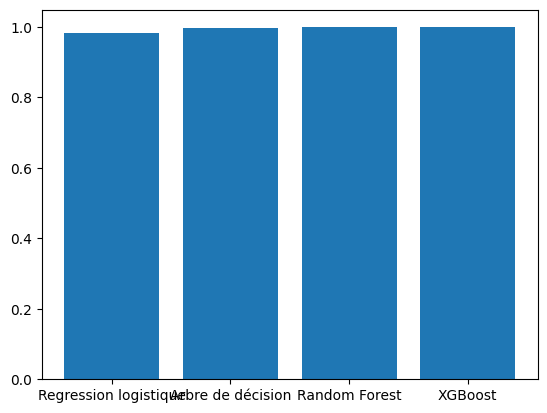

In [20]:
# On entraine nos modeles en utilisant la cross validation et on recupere la matrice de confusion
from sklearn.model_selection import cross_val_score

scores_reg = cross_val_score(model_reg, X_train, y_train, cv=5, scoring='f1')
scores_tree = cross_val_score(model_tree, X_train, y_train, cv=5, scoring='f1')
scores_random_forest = cross_val_score(model_random_forest, X_train, y_train, cv=5, scoring='f1')
scores_XGBoost = cross_val_score(model_XGBoost, X_train, y_train, cv=5, scoring='f1')

# On plot nos scores f1 dans un graphique en barres
scores = [scores_reg.mean(), scores_tree.mean(), scores_random_forest.mean(), scores_XGBoost.mean()]
names = ['Regression logistique', 'Arbre de décision', 'Random Forest', 'XGBoost']
plt.bar(names, scores)
plt.show()

### 2.5 Entrainement du modèle
Maintenant que nous connaissons le modèle le plus performant, nous allons l'entrainer sur l'ensemble du jeu de données d'entrainement.

In [42]:
model = model_XGBoost
model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=50, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=0, ...)

## 3. Prédictions
Nous pouvons pouvons désormais utiliser notre modèle pour réaliser des prédictions sur notre jeu de données de test. Nous allons ensuite exporter nos predictions dans un fichier csv afin de les soumettre sur la plateforme Zindi.

In [43]:
# On retire les colonnes de X_test qui ne sont pas dans X_train
X_test = X_test[X.columns]

predictions = model.predict(X_test)
# we print the first 5 predictions
print(predictions[:5])

# On réintègre la colonne TransactionId a partir de X_test_index
X_test['TransactionId'] = X_test_id

# We create a dataframe containing the TransactionId and the predictions
submission = pd.DataFrame({'TransactionId': X_test.TransactionId, 'FraudResult': predictions})
print(submission.head())

# We add 'TransactionId_' to the TransactionId column
submission['TransactionId'] = submission['TransactionId'].astype(str)

# We save the dataframe as a csv file
submission.to_csv('submission.csv', index=False)

submission.head()

[0 0 0 0 0]
         TransactionId  FraudResult
0  TransactionId_50600            0
1  TransactionId_95109            0
2  TransactionId_47357            0
3  TransactionId_28185            0
4  TransactionId_22140            0


,TransactionId,FraudResult
0,TransactionId_50600,0
1,TransactionId_95109,0
2,TransactionId_47357,0
3,TransactionId_28185,0
4,TransactionId_22140,0


## 4. Conclusion
